# Employee Attrition & Prevention with Clustering

In [ ]:
# import modul

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mnso
from scipy.stats import ttest_ind
from scipy.stats import skew,skewtest,spearmanr,pearsonr,normaltest
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans


from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import RobustScaler,OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, precision_recall_curve,make_scorer,accuracy_score, precision_score, recall_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Data Understanding

In [ ]:
# Load the dataset

data = pd.read_csv('HR_comma_sep.csv')
data

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


## Data Description

In [ ]:
# Data Checking

data = data.rename(columns={'sales':'department'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [ ]:
# Check the duplicates

data.duplicated().sum()

3008

In [ ]:
# Drop the duplicates

data = data.drop_duplicates()
data.duplicated().sum()

0

In [ ]:
# Check the missing value

data.isna().sum()/len(data)

satisfaction_level       0.0
last_evaluation          0.0
number_project           0.0
average_montly_hours     0.0
time_spend_company       0.0
Work_accident            0.0
left                     0.0
promotion_last_5years    0.0
department               0.0
salary                   0.0
dtype: float64

## Exploratory Data Analysis

In [ ]:
# Dividing the data based on type 

data_num = data.select_dtypes('number')
data_cat = data.select_dtypes('object')

In [ ]:
data_num.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years'],
      dtype='object')

In [ ]:
data_cat.columns

Index(['department', 'salary'], dtype='object')

In [ ]:
# Checking the statistic attribute

data_num.describe().T

,count,mean,std,min,25%,50%,75%,max
satisfaction_level,11991.0,0.629658,0.241070,0.09,0.48,0.66,0.82,1.0
last_evaluation,11991.0,0.716683,0.168343,0.36,0.57,0.72,0.86,1.0
number_project,11991.0,3.802852,1.163238,2.00,3.00,4.00,5.00,7.0
average_montly_hours,11991.0,200.473522,48.727813,96.00,157.00,200.00,243.00,310.0
time_spend_company,11991.0,3.364857,1.330240,2.00,3.00,3.00,4.00,10.0
Work_accident,11991.0,0.154282,0.361234,0.00,0.00,0.00,0.00,1.0
left,11991.0,0.166041,0.372133,0.00,0.00,0.00,0.00,1.0
promotion_last_5years,11991.0,0.016929,0.129012,0.00,0.00,0.00,0.00,1.0


In [ ]:
# Checking the statistic attribute

data_cat.describe().T

,count,unique,top,freq
department,11991,10,sales,3239
salary,11991,3,low,5740



Iterasi ke- 1
Kolom :  satisfaction_level


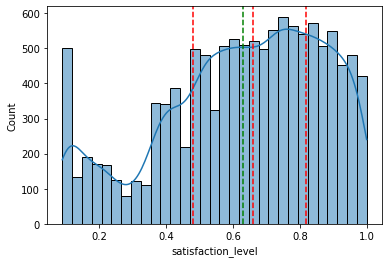

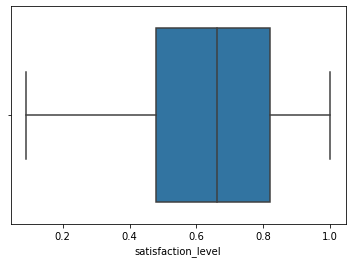


Skew Value :  -0.5386342743478788
Skew Test Value :  SkewtestResult(statistic=-22.622737443150548, pvalue=2.5890719306016417e-113)
count    11991.000000
mean         0.629658
std          0.241070
min          0.090000
25%          0.480000
50%          0.660000
75%          0.820000
max          1.000000
Name: satisfaction_level, dtype: float64

nilai max di luar outlier = 1.0
nilai min di luar outlier = 0.09
jumlah outlier:0
outlier:
[]


Iterasi ke- 2
Kolom :  last_evaluation


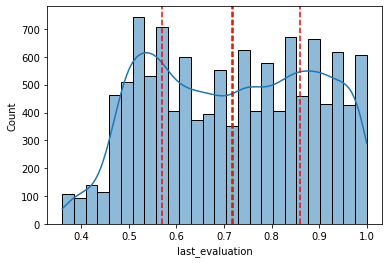

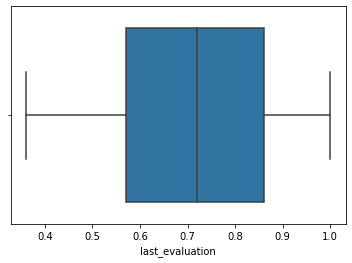


Skew Value :  -0.031682111330650055
Skew Test Value :  SkewtestResult(statistic=-1.4168654813071035, pvalue=0.15652226042435977)
count    11991.000000
mean         0.716683
std          0.168343
min          0.360000
25%          0.570000
50%          0.720000
75%          0.860000
max          1.000000
Name: last_evaluation, dtype: float64

nilai max di luar outlier = 1.0
nilai min di luar outlier = 0.36
jumlah outlier:0
outlier:
[]


Iterasi ke- 3
Kolom :  number_project


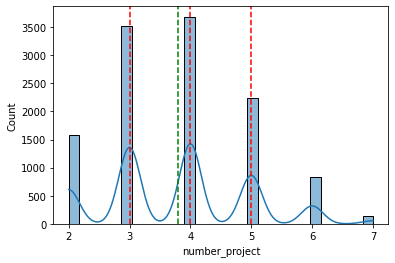

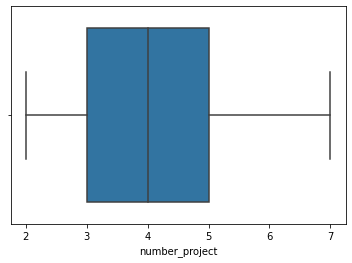


Skew Value :  0.33211043493855935
Skew Test Value :  SkewtestResult(statistic=14.474948462372863, pvalue=1.7445645643056966e-47)
count    11991.000000
mean         3.802852
std          1.163238
min          2.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          7.000000
Name: number_project, dtype: float64

nilai max di luar outlier = 7
nilai min di luar outlier = 2
jumlah outlier:0
outlier:
[]


Iterasi ke- 4
Kolom :  average_montly_hours


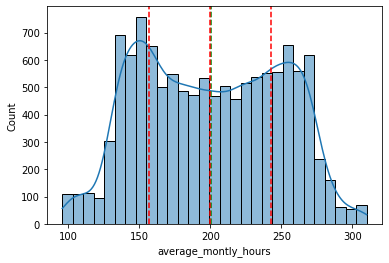

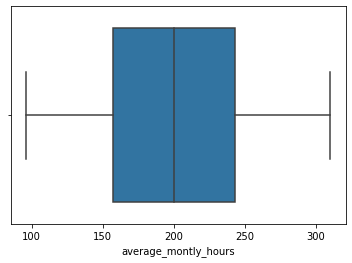


Skew Value :  0.027204633327374373
Skew Test Value :  SkewtestResult(statistic=1.2167067763449253, pvalue=0.2237157999191618)
count    11991.000000
mean       200.473522
std         48.727813
min         96.000000
25%        157.000000
50%        200.000000
75%        243.000000
max        310.000000
Name: average_montly_hours, dtype: float64

nilai max di luar outlier = 310
nilai min di luar outlier = 96
jumlah outlier:0
outlier:
[]


Iterasi ke- 5
Kolom :  time_spend_company


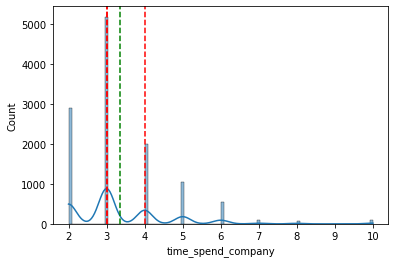

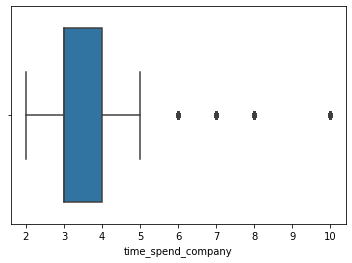


Skew Value :  1.8163498579672368
Skew Test Value :  SkewtestResult(statistic=56.260279483517024, pvalue=0.0)
count    11991.000000
mean         3.364857
std          1.330240
min          2.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         10.000000
Name: time_spend_company, dtype: float64

nilai max di luar outlier = 5
nilai min di luar outlier = 2
jumlah outlier:824
outlier:
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6

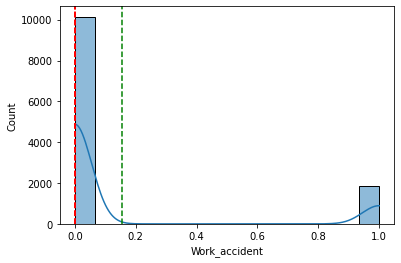

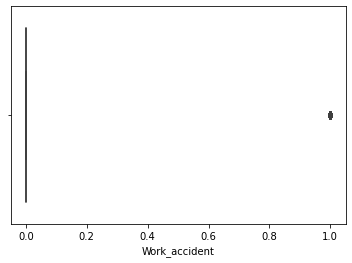


Skew Value :  1.9141706794552746
Skew Test Value :  SkewtestResult(statistic=58.016610772244114, pvalue=0.0)
count    11991.000000
mean         0.154282
std          0.361234
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Work_accident, dtype: float64

nilai max di luar outlier = 0
nilai min di luar outlier = 0
jumlah outlier:1850
outlier:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

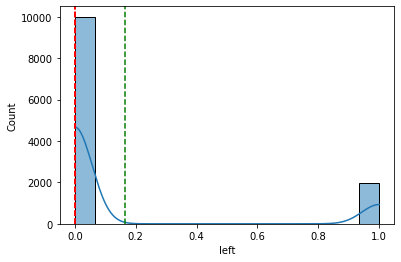

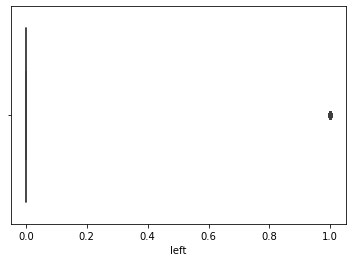


Skew Value :  1.7949099441711793
Skew Test Value :  SkewtestResult(statistic=55.864809786055694, pvalue=0.0)
count    11991.000000
mean         0.166041
std          0.372133
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: left, dtype: float64

nilai max di luar outlier = 0
nilai min di luar outlier = 0
jumlah outlier:1991
outlier:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

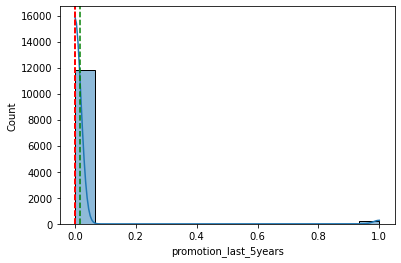

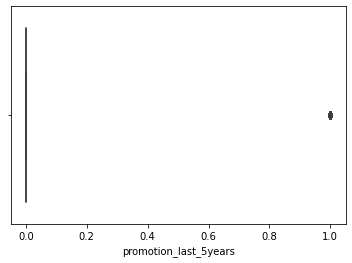


Skew Value :  7.489071131979866
Skew Test Value :  SkewtestResult(statistic=106.43374163003872, pvalue=0.0)
count    11991.000000
mean         0.016929
std          0.129012
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: promotion_last_5years, dtype: float64

nilai max di luar outlier = 0
nilai min di luar outlier = 0
jumlah outlier:203
outlier:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
# EDA for univariate analysis

# numeric data list
list_kontinu = list(data_num.columns)

# loop
iter = 1
for i in list_kontinu:
  print()
  print('Iterasi ke-',iter)
  print('Kolom : ',i)
  sns.histplot(data_num[i],kde=True)
  plt.axvline(np.mean(data_num[i]),c='green',linestyle='--')
  plt.axvline(np.percentile(data_num[i],25),c='red',linestyle='--')
  plt.axvline(np.percentile(data_num[i],50),c='red',linestyle='--')
  plt.axvline(np.percentile(data_num[i],75),c='red',linestyle='--')
  plt.show()
  sns.boxplot(data=data_num, x=data_num[i])
  plt.show()

  print()
  print('Skew Value : ',skew(data_num[i]))
  print('Skew Test Value : ',skewtest(data_num[i]))
  print(data_num[i].describe())
  
  print()
  Q1 = np.percentile(data_num[i],25)
  Q2 = np.percentile(data_num[i],50)
  Q3 = np.percentile(data_num[i],75)
  IQR = Q3-Q1

  upper_f = Q3 + 1.5 * IQR
  lower_f = Q1 - 1.5 * IQR

  upper_w = np.max(data_num[data_num[i] <= upper_f][i])
  lower_w = np.min(data_num[data_num[i] >= lower_f][i])
  outlier = list(data_num[(data_num[i] < lower_w) | (data_num[i] > upper_f)][i])

  print('nilai max di luar outlier = {}'.format(upper_w))
  print('nilai min di luar outlier = {}'.format(lower_w))
  print('jumlah outlier:{}'.format(len(outlier)))
  print('outlier:')
  print(outlier)
  iter+=1
  print()


Iterasi ke- 1
Kolom :  department


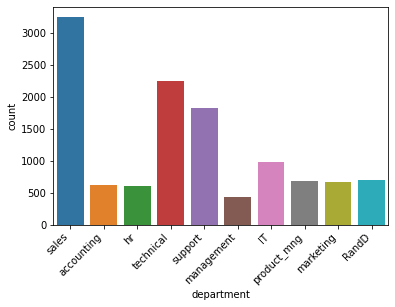

Jumlah kategori unik : 10
Jumlah nilai kategori unik : ['sales', 'accounting', 'hr', 'technical', 'support', 'management', 'IT', 'product_mng', 'marketing', 'RandD']
Jumlah total nilai kategori unik :
sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: department, dtype: int64


Iterasi ke- 2
Kolom :  salary


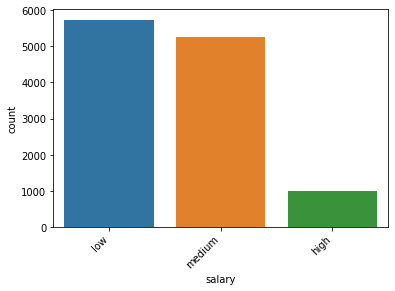

Jumlah kategori unik : 3
Jumlah nilai kategori unik : ['low', 'medium', 'high']
Jumlah total nilai kategori unik :
low       5740
medium    5261
high       990
Name: salary, dtype: int64



In [ ]:
# categorical list
list_kategori = list(data_cat.columns)

# loop
iter = 1
for i in list_kategori:
  print()
  print('Iterasi ke-',iter)
  print('Kolom : ',i)
  sns.countplot(data = data_cat, x = i)
  plt.xticks(rotation=45, ha='right')
  plt.show()
    
  print('Jumlah kategori unik :', len(data_cat[i].unique()))
  print('Jumlah nilai kategori unik :', list(data_cat[i].unique()))
  print('Jumlah total nilai kategori unik :')
  print(data_cat[i].value_counts())
  iter+=1
  print()


iterasi ke- 1
Hubungan label dengan kolom satisfaction_level


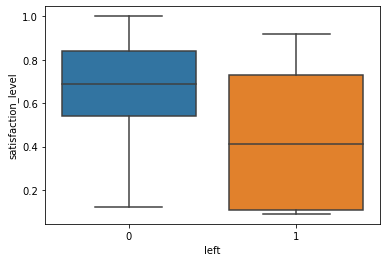

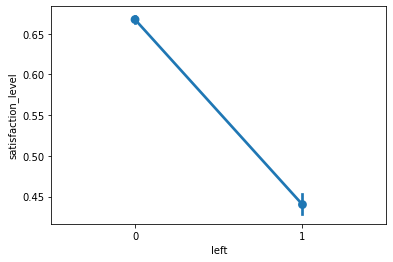

Nilai t-test : -40.98502015841721
Nilai pvalue t-test : 0.0
Dikarenakan nilai pvalue ttest < 0.05 maka terima H0
Kesimpulan : mean variabel numerik kelompok label 1 = mean variabel numerik kelompok label 0


iterasi ke- 2
Hubungan label dengan kolom last_evaluation


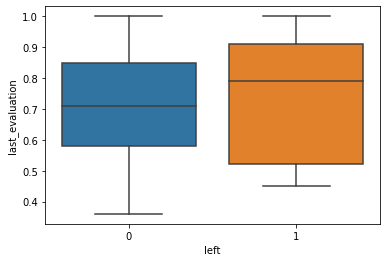

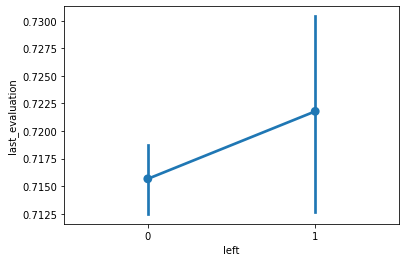

Nilai t-test : 1.480487450460807
Nilai pvalue t-test : 0.13876948482810622
Dikarenakan nilai pvalue ttest > 0.05 maka tolak H0
Kesimpulan : mean variabel numerik kelompok label 1 ≠ mean variabel numerik kelompok label 0


iterasi ke- 3
Hubungan label dengan kolom number_project


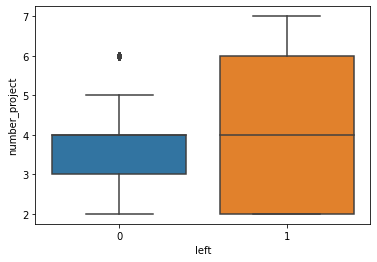

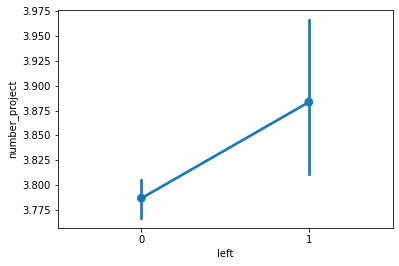

Nilai t-test : 3.3880208345839424
Nilai pvalue t-test : 0.0007062542110999653
Dikarenakan nilai pvalue ttest < 0.05 maka terima H0
Kesimpulan : mean variabel numerik kelompok label 1 = mean variabel numerik kelompok label 0


iterasi ke- 4
Hubungan label dengan kolom average_montly_hours


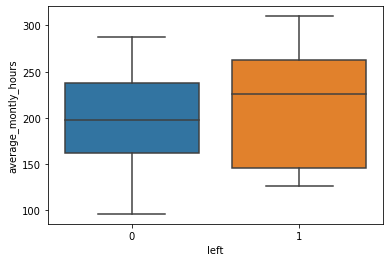

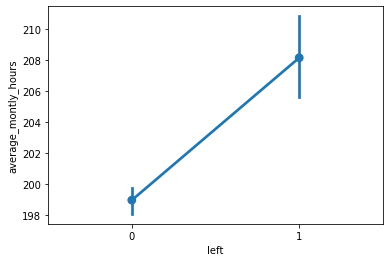

Nilai t-test : 7.7286004860688795
Nilai pvalue t-test : 1.1739390712865618e-14
Dikarenakan nilai pvalue ttest < 0.05 maka terima H0
Kesimpulan : mean variabel numerik kelompok label 1 = mean variabel numerik kelompok label 0


iterasi ke- 5
Hubungan label dengan kolom time_spend_company


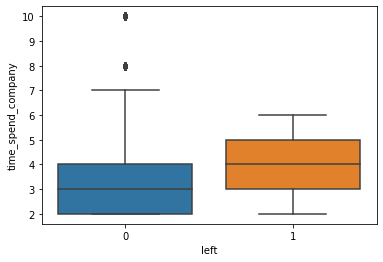

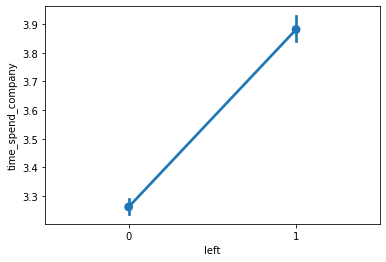

Nilai t-test : 19.266329594172518
Nilai pvalue t-test : 1.745810653156104e-81
Dikarenakan nilai pvalue ttest < 0.05 maka terima H0
Kesimpulan : mean variabel numerik kelompok label 1 = mean variabel numerik kelompok label 0


iterasi ke- 6
Hubungan label dengan kolom Work_accident


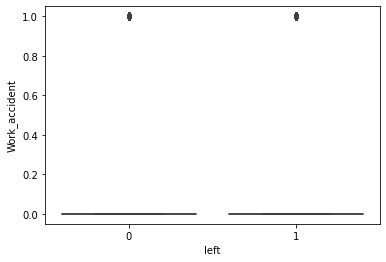

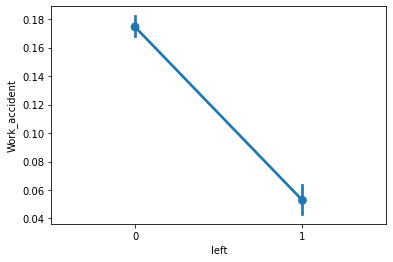

Nilai t-test : -13.843913679957346
Nilai pvalue t-test : 2.977777859015827e-43
Dikarenakan nilai pvalue ttest < 0.05 maka terima H0
Kesimpulan : mean variabel numerik kelompok label 1 = mean variabel numerik kelompok label 0


iterasi ke- 7
Hubungan label dengan kolom promotion_last_5years


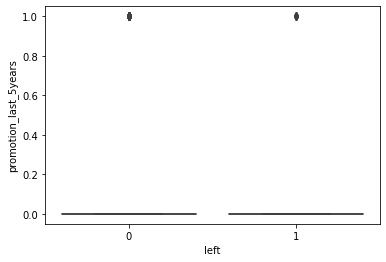

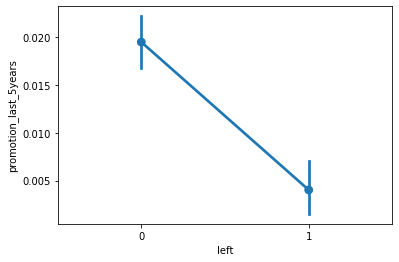

Nilai t-test : -4.894600965630227
Nilai pvalue t-test : 9.978781593281159e-07
Dikarenakan nilai pvalue ttest < 0.05 maka terima H0
Kesimpulan : mean variabel numerik kelompok label 1 = mean variabel numerik kelompok label 0



In [ ]:
# EDA for multivariate

# continous data type
# list without left
list_kontinu = list(data_num.columns)
list_kontinu.remove('left')

# Membuat loop
iter=1
for i in list_kontinu:
  print()
  print('iterasi ke-',iter)
  print('Hubungan label dengan kolom',i)
  
  sns.boxplot(data=data, x='left', y=i)
  plt.show()
  print()
  sns.pointplot(data=data, x='left', y=i,kind='point')
  plt.show()

  alp = 0.05
  group1 = data[(data['left']==1)][i]
  group0 = data[(data['left']==0)][i]
  ttest_coef,ttest_pval = ttest_ind(group1,group0,nan_policy='omit', alternative='two-sided')
  print('Nilai t-test :',ttest_coef)
  print('Nilai pvalue t-test :',ttest_pval)
  if ttest_pval < 0.05 :
    print('Dikarenakan nilai pvalue ttest < 0.05 maka terima H0')
    print('Kesimpulan : mean variabel numerik kelompok label 1 = mean variabel numerik kelompok label 0')
  else : 
    print('Dikarenakan nilai pvalue ttest > 0.05 maka tolak H0')
    print('Kesimpulan : mean variabel numerik kelompok label 1 ≠ mean variabel numerik kelompok label 0')

  iter+=1
  print()

Insight : Pegawai yang left cenderung memiliki rata-rata nilai kepuasan rendah, peforma evaluasi lebih tinggi, mengerjakan projek lebih banyak, bekerja dengan waktu lebih banyak, kecelakaan kerja rendah, dan tidak dipromosikan dalam 5 tahun belakangan.

iterasi ke- 1
Hubungan label dengan kolom department


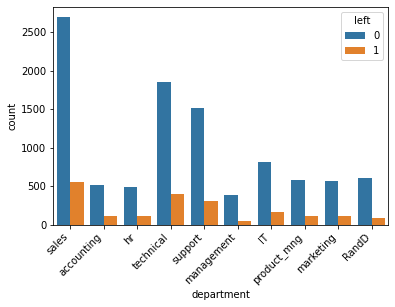

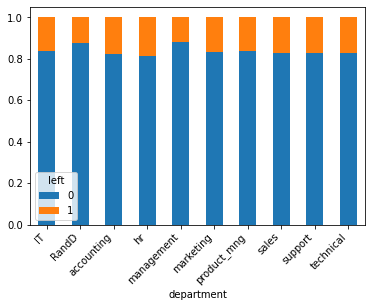


iterasi ke- 2
Hubungan label dengan kolom salary


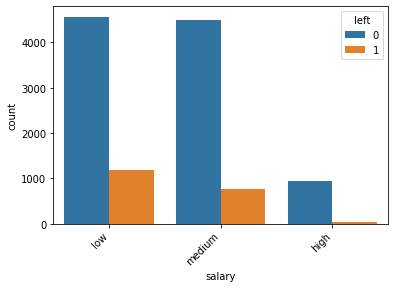

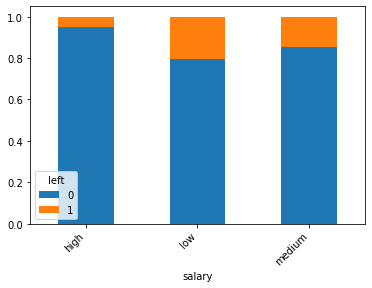

In [ ]:
# EDA for multivariate

# categorical data type
list_kategorikal = list(data_cat.columns)

iter = 1
# loop
for i in list_kategorikal:
  print('iterasi ke-',iter)
  print('Hubungan label dengan kolom',i)
  sns.countplot(data=data_cat, x=i, hue=data['left'])
  plt.xticks(rotation=45, ha='right')
  plt.show()
  pd.crosstab(data_cat[i], data['left'], normalize='index').plot(kind='bar', stacked=True)
  plt.xticks(rotation=45, ha='right')
  plt.show()
  iter+=1
  print()

Insight : jumlah persentase pegawai keluar tertinggi berada pada departemen HR dan Accounting, sedangkan jika dilihat dari gaji maka pegawai dengan gaji rendah tertinggi untuk peluang keluarnya pegawai.

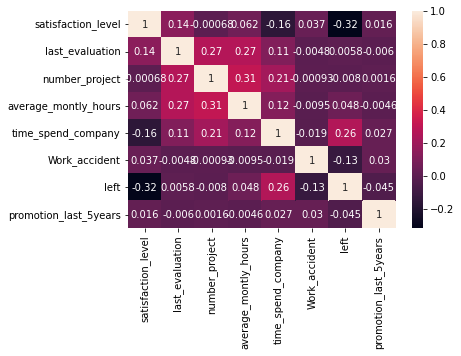

In [ ]:
# Variable correlation

ax, fig = plt.subplots()
corr = data.corr(method='spearman')
sns.heatmap(corr,annot=True)

In [ ]:
# Number of employee attrited

data['left'].value_counts()

0    10000
1     1991
Name: left, dtype: int64

# Employee Attrition

## Data Preparation & Feature Engineering

In [ ]:
# Defining variabel X and Y

X = data.drop(['left'],axis=1)
Y = data['left']

In [ ]:
# Checking the rasio label 0 and 1

Y.value_counts(normalize=True)

0    0.833959
1    0.166041
Name: left, dtype: float64

In [ ]:
# Defining train test split

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=42)

In [ ]:
# Checking the train test size

print('X train :',X_train.shape)
print('y train :',y_train.shape)
print('X test :',X_test.shape)
print('y test :',y_test.shape)

X train : (9592, 9)
y train : (9592,)
X test : (2399, 9)
y test : (2399,)


In [ ]:
# Data Train

In [ ]:
# Dividing the train data based on type

X_train_num = X_train.select_dtypes('number')
X_train_cat = X_train.select_dtypes('object')

In [ ]:
# Continous train data Scaling 

rs = RobustScaler()
X_train_sc = pd.DataFrame(rs.fit_transform(X_train_num), columns = rs.feature_names_in_)
X_train_sc

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
0,0.934307,0.633333,0.0,0.465116,0.0,0.0,0.0
1,-0.087591,0.566667,-0.5,0.453488,0.0,0.0,0.0
2,0.554745,-0.433333,-0.5,0.406977,0.0,0.0,0.0
3,-0.291971,-1.100000,-0.5,-1.093023,5.0,0.0,0.0
4,-0.467153,0.100000,1.0,-0.848837,0.0,0.0,0.0
...,...,...,...,...,...,...,...
9587,0.671533,0.600000,0.0,-0.546512,0.0,0.0,0.0
9588,-0.262774,-1.000000,-1.0,0.558140,1.0,0.0,0.0
9589,0.554745,-0.100000,0.5,0.848837,0.0,1.0,0.0
9590,0.000000,-0.333333,-0.5,-0.651163,0.0,0.0,0.0


In [ ]:
# Categorical train data encoder

ohe = OneHotEncoder(handle_unknown='ignore')
X_train_enc = pd.DataFrame(ohe.fit_transform(X_train_cat).toarray(),columns =ohe.get_feature_names_out(X_train_cat.columns))
X_train_enc

,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
9588,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9589,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9590,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Merge dataset
X_train_concat = pd.concat([X_train_sc, X_train_enc], axis = 1)
X_train_concat

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.934307,0.633333,0.0,0.465116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-0.087591,0.566667,-0.5,0.453488,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.554745,-0.433333,-0.5,0.406977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-0.291971,-1.100000,-0.5,-1.093023,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.467153,0.100000,1.0,-0.848837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9587,0.671533,0.600000,0.0,-0.546512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
9588,-0.262774,-1.000000,-1.0,0.558140,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9589,0.554745,-0.100000,0.5,0.848837,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9590,0.000000,-0.333333,-0.5,-0.651163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Data Test

In [ ]:
# Dividing the train data based on type

X_test_num = X_test.select_dtypes('number')
X_test_cat = X_test.select_dtypes('object')

In [ ]:
# Continous train data Scaling 

X_test_sc = pd.DataFrame(rs.transform(X_test_num), columns = rs.feature_names_in_)
X_test_sc

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
0,0.934307,-0.933333,0.0,-0.534884,3.0,1.0,0.0
1,-0.759124,-0.766667,-1.0,-0.755814,0.0,0.0,0.0
2,-1.051095,-0.166667,-0.5,0.372093,0.0,0.0,0.0
3,0.875912,-0.666667,0.0,0.325581,0.0,0.0,0.0
4,-1.635036,0.833333,1.5,0.627907,1.0,0.0,0.0
...,...,...,...,...,...,...,...
2394,-0.642336,-0.166667,0.5,-0.348837,0.0,1.0,0.0
2395,-0.700730,-0.733333,0.5,1.000000,1.0,0.0,0.0
2396,0.350365,-0.766667,-0.5,0.279070,0.0,0.0,0.0
2397,-1.284672,-0.066667,-1.0,0.860465,7.0,0.0,0.0


In [ ]:
# Categorical train data encoder

X_test_enc = pd.DataFrame(ohe.transform(X_test_cat).toarray(),columns =ohe.get_feature_names_out(X_test_cat.columns))
X_test_enc

,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2394,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# Merge dataset
X_test_concat = pd.concat([X_test_sc, X_test_enc], axis = 1)
X_test_concat

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.934307,-0.933333,0.0,-0.534884,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-0.759124,-0.766667,-1.0,-0.755814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-1.051095,-0.166667,-0.5,0.372093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.875912,-0.666667,0.0,0.325581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-1.635036,0.833333,1.5,0.627907,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2394,-0.642336,-0.166667,0.5,-0.348837,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2395,-0.700730,-0.733333,0.5,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2396,0.350365,-0.766667,-0.5,0.279070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2397,-1.284672,-0.066667,-1.0,0.860465,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Modeling

In [ ]:
# Declaring function

def classif(estimator, x, y):
    y_pred = estimator.predict(x)
    print(classification_report(y, y_pred, labels=[1,0]))

def list_metrcis_model(model,y_test, y_pred):
    from sklearn import metrics
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report)
    df_classification = df_classification_report.iloc[0:3,0:3]
    preci = df_classification.iloc[0,1]
    reca = df_classification.iloc[1,1]
    tnr = df_classification.iloc[1,0]
    fpr = 1-tnr
    npv = df_classification.iloc[0,0]
    f1 = df_classification.iloc[2,1]
    acc = df_classification.iloc[0,2]
    output_list = [model,preci,reca,tnr,fpr,npv,f1,acc]
    return output_list

In [ ]:
# Classification Model used

log = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
xg = XGBClassifier(random_state=42)

In [ ]:
# Fitting model

log.fit(X_train_concat, y_train)
y_train_pred_log = log.predict(X_train_concat)
y_test_pred_log = log.predict(X_test_concat)

dt.fit(X_train_concat, y_train)
y_train_pred_dt = dt.predict(X_train_concat)
y_test_pred_dt = dt.predict(X_test_concat)

rf.fit(X_train_concat, y_train)
y_train_pred_rf = rf.predict(X_train_concat)
y_test_pred_rf = rf.predict(X_test_concat)

ada.fit(X_train_concat, y_train)
y_train_pred_ada = ada.predict(X_train_concat)
y_test_pred_ada = ada.predict(X_test_concat)

xg.fit(X_train_concat, y_train)
y_train_pred_xg = xg.predict(X_train_concat)
y_test_pred_xg = xg.predict(X_test_concat)

In [ ]:
# Defining metrics list in dataframe

train_metric_log = list_metrcis_model('Log_train',y_train,y_train_pred_log)
test_metric_log = list_metrcis_model('Log_test',y_test,y_test_pred_log)
df_log_train = pd.DataFrame(train_metric_log).T
df_log_test = pd.DataFrame(test_metric_log).T
df_log_train.columns=['model','precision','recall','TNR','FPR','NPV','f1_score','accuracy']
df_log_test.columns=['model','precision','recall','TNR','FPR','NPV','f1_score','accuracy']

train_metric_dt = list_metrcis_model('DT_train',y_train,y_train_pred_dt)
test_metric_dt = list_metrcis_model('DT_test',y_test,y_test_pred_dt)
df_dt_train = pd.DataFrame(train_metric_dt).T
df_dt_test = pd.DataFrame(test_metric_dt).T
df_dt_train.columns=['model','precision','recall','TNR','FPR','NPV','f1_score','accuracy']
df_dt_test.columns=['model','precision','recall','TNR','FPR','NPV','f1_score','accuracy']

train_metric_rf = list_metrcis_model('RF_train',y_train,y_train_pred_rf)
test_metric_rf = list_metrcis_model('RF_test',y_test,y_test_pred_rf)
df_rf_train = pd.DataFrame(train_metric_rf).T
df_rf_test = pd.DataFrame(test_metric_rf).T
df_rf_train.columns=['model','precision','recall','TNR','FPR','NPV','f1_score','accuracy']
df_rf_test.columns=['model','precision','recall','TNR','FPR','NPV','f1_score','accuracy']

train_metric_ada = list_metrcis_model('ada_train',y_train,y_train_pred_ada)
test_metric_ada = list_metrcis_model('ada_test',y_test,y_test_pred_ada)
df_ada_train = pd.DataFrame(train_metric_ada).T
df_ada_test = pd.DataFrame(test_metric_ada).T
df_ada_train.columns=['model','precision','recall','TNR','FPR','NPV','f1_score','accuracy']
df_ada_test.columns=['model','precision','recall','TNR','FPR','NPV','f1_score','accuracy']

train_metric_xg = list_metrcis_model('xg_train',y_train,y_train_pred_xg)
test_metric_xg = list_metrcis_model('xg_test',y_test,y_test_pred_xg)
df_xg_train = pd.DataFrame(train_metric_xg).T
df_xg_test = pd.DataFrame(test_metric_xg).T
df_xg_train.columns=['model','precision','recall','TNR','FPR','NPV','f1_score','accuracy']
df_xg_test.columns=['model','precision','recall','TNR','FPR','NPV','f1_score','accuracy']

In [ ]:
# Model result

df_classification_all = pd.concat([df_log_train,df_log_test,
                                   df_dt_train,df_dt_test,
                                   df_rf_train,df_rf_test,
                                   df_ada_train,df_ada_test,
                                   df_xg_train,df_xg_test]).reset_index()
df_classification_all = df_classification_all.drop(['index'],axis=1)
df_classification_all

,model,precision,recall,TNR,FPR,NPV,f1_score,accuracy
0,Log_train,0.511346,0.212178,0.95962,0.04038,0.859478,0.299911,0.835488
1,Log_test,0.502959,0.213568,0.958021,0.041979,0.859641,0.299824,0.834514
2,DT_train,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,DT_test,0.889157,0.927136,0.977011,0.022989,0.985383,0.907749,0.968737
4,RF_train,1.0,1.0,1.0,0.0,1.0,1.0,1.0
5,RF_test,0.986631,0.927136,0.997501,0.002499,0.985679,0.955959,0.985827
6,ada_train,0.908322,0.876962,0.982373,0.017627,0.975664,0.892367,0.964867
7,ada_test,0.899244,0.896985,0.98001,0.01999,0.97952,0.898113,0.966236
8,xg_train,0.969038,0.923415,0.994124,0.005876,0.98489,0.945677,0.982381
9,xg_test,0.955959,0.927136,0.991504,0.008496,0.985594,0.941327,0.980825


In [ ]:
# Based on result above, the default XGBoost model haa the highest metrics compared to other models. 
# For the optimum result, we will try to improve the peformance by tuning the model.

## Model Tuning

### XGBoost

In [ ]:
# Melakukan hyperparameter tunning agar memenuhi kriteria

# Parameter : learning_rate, n_estimators, max_depth, gamma, reg_lambda, min_child_weight

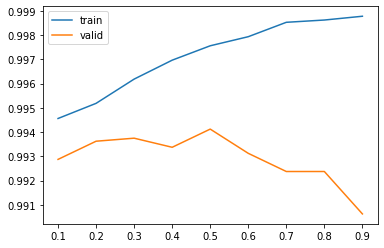

In [ ]:
learning_rate = np.arange(0.1,1,0.1)
train = []
valid = []
a = []
for x in learning_rate:
    result = cross_validate(XGBClassifier(learning_rate=x,
                                          random_state=42),
                            X_train_concat,
                            y_train,
                            cv=5,
                            scoring = make_scorer(recall_score,pos_label=0),
                            return_train_score= True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

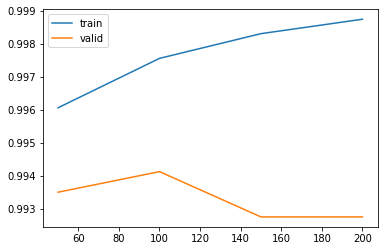

In [ ]:
n_estimators = np.arange(50,250,50)
train = []
valid = []
a = []
for x in n_estimators:
    result = cross_validate(XGBClassifier(n_estimators=x,
                                          learning_rate=0.5,
                                          random_state=42),
                            X_train_concat,
                            y_train,
                            cv=5,
                            scoring = make_scorer(recall_score,pos_label=0),
                            return_train_score= True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

In [ ]:
a[np.argmax(valid)]

100

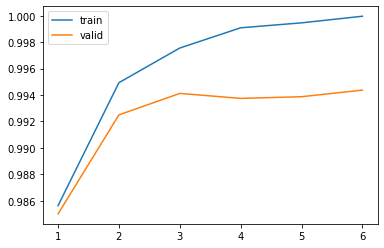

In [ ]:
max_depth = np.arange(1,7,1)
train = []
valid = []
a = []
for x in max_depth:
    result = cross_validate(XGBClassifier(n_estimators=100,
                                          learning_rate=0.5,
                                          max_depth=x,
                                          random_state=42),
                            X_train_concat,
                            y_train,
                            cv=5,
                            scoring = make_scorer(recall_score,pos_label=0),
                            return_train_score= True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

In [ ]:
a[np.argmax(valid)]

6

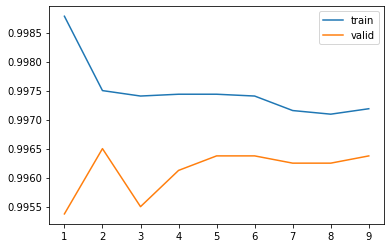

In [ ]:
gamma = np.arange(1,10,1)
train = []
valid = []
a = []
for x in gamma:
    result = cross_validate(XGBClassifier(n_estimators=100,
                                          learning_rate=0.5,
                                          max_depth=6,
                                          gamma=x,
                                          random_state=42),
                            X_train_concat,
                            y_train,
                            cv=5,
                            scoring = make_scorer(recall_score,pos_label=0),
                            return_train_score= True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

In [ ]:
a[np.argmax(valid)]

2

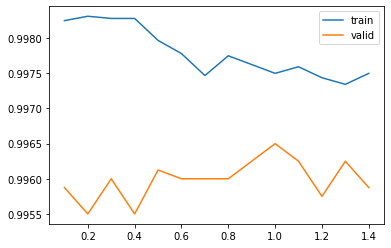

In [ ]:
reg_lambda = np.arange(0.1,1.5,0.1)
train = []
valid = []
a = []
for x in reg_lambda:
    result = cross_validate(XGBClassifier(n_estimators=100,
                                          learning_rate=0.5,
                                          max_depth=6,
                                          gamma=2,
                                          reg_lambda=x,
                                          random_state=42),
                            X_train_concat,
                            y_train,
                            cv=5,
                            scoring = make_scorer(recall_score,pos_label=0),
                            return_train_score= True)
    train.append(result['train_score'].mean())
    valid.append(result['test_score'].mean())
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

In [ ]:
a[np.argmax(valid)]

1.0

In [ ]:
# Mendefiniskan dan fitting model xgboost optimum

xg_opt = XGBClassifier(n_estimators=100,
                   learning_rate=0.5,
                   max_depth=6,
                   gamma=2,
                   reg_lambda=1,
                   random_state=42)

xg_opt.fit(X_train_concat, y_train)

y_train_pred_xg_opt = xg_opt.predict(X_train_concat)
y_test_pred_xg_opt = xg_opt.predict(X_test_concat)

In [ ]:
# Melihat hasil fitting model xg default pada data train

print(classification_report(y_train, y_train_pred_xg_opt, labels=[1,0]))

              precision    recall  f1-score   support

           1       0.99      0.94      0.97      1593
           0       0.99      1.00      0.99      7999

    accuracy                           0.99      9592
   macro avg       0.99      0.97      0.98      9592
weighted avg       0.99      0.99      0.99      9592



In [ ]:
# Melihat hasil fitting model xg default pada data test

print(classification_report(y_test, y_test_pred_xg_opt, labels=[1,0]))

              precision    recall  f1-score   support

           1       0.96      0.93      0.95       398
           0       0.99      0.99      0.99      2001

    accuracy                           0.98      2399
   macro avg       0.98      0.96      0.97      2399
weighted avg       0.98      0.98      0.98      2399



Jika dibandingkan dengan hasil XGBosst default maka hasilnya tidak berbeda jauh sehingga model terbaik adalah XGBoost default.

## Feature Importance

In [ ]:
# Making feature importance dataframe

feat_imp = pd.DataFrame({'feature':X_train_concat.columns,'importance':xg.feature_importances_}).sort_values('importance',ascending=False)
feat_imp

,feature,importance
0,satisfaction_level,0.302985
4,time_spend_company,0.202140
2,number_project,0.173416
1,last_evaluation,0.123303
3,average_montly_hours,0.082619
5,Work_accident,0.040584
17,salary_high,0.037730
18,salary_low,0.037223
13,department_product_mng,0.000000
16,department_technical,0.000000


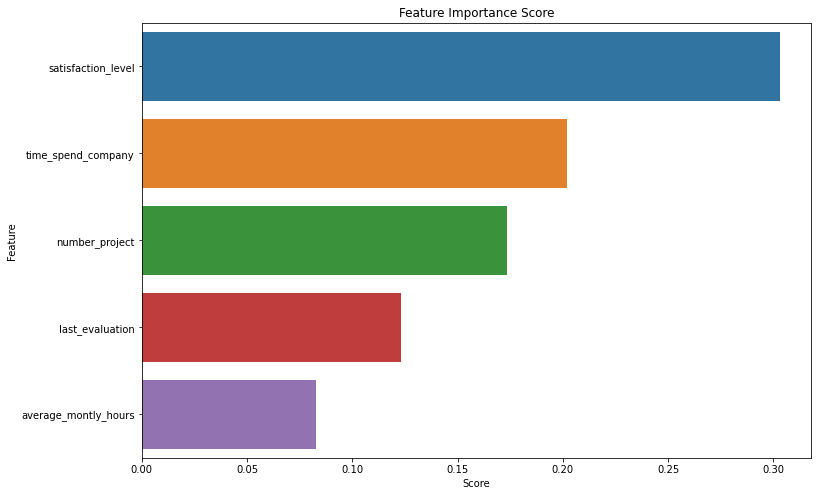

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(data=feat_imp.nlargest(5,columns='importance'),x='importance',y='feature')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.title('Feature Importance Score')
plt.show()

## Confusion Matrix

Text(0, 0.5, 'True Label')

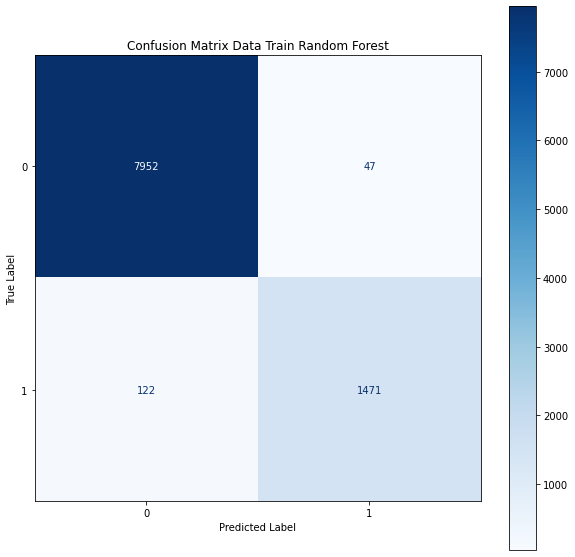

In [ ]:
# DATA TRAIN

fig, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(y_train, y_train_pred_xg)
matrix = plot_confusion_matrix(xg, X_train_concat, y_train, cmap=plt.cm.Blues, ax=ax)
matrix.ax_.set_title('Confusion Matrix Data Train Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

Text(0, 0.5, 'True Label')

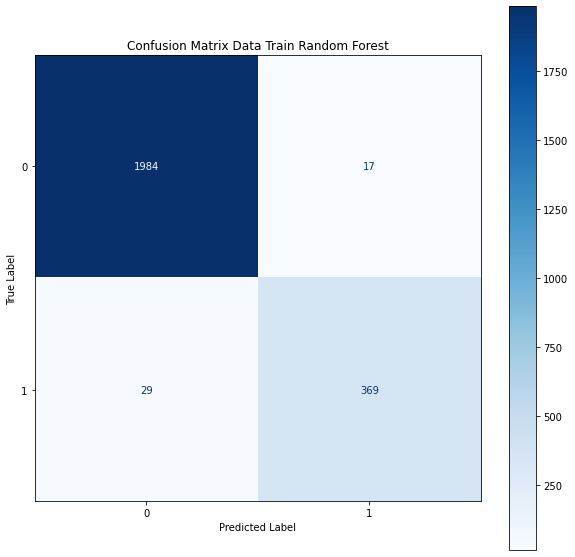

In [ ]:
# DATA TEST

fig, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(y_test, y_test_pred_xg)
matrix = plot_confusion_matrix(xg, X_test_concat, y_test, cmap=plt.cm.Blues, ax=ax)
matrix.ax_.set_title('Confusion Matrix Data Train Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Clustering for prevention




Feature Transformation

In [ ]:
# Continous data Scaling 

rsc = RobustScaler()
data_num_scl = pd.DataFrame(rsc.fit_transform(data_num), columns = rsc.feature_names_in_)
data_num_scl

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
0,-0.823529,-0.655172,-1.0,-0.500000,0.0,0.0,1.0,0.0
1,0.411765,0.482759,0.5,0.720930,3.0,0.0,1.0,0.0
2,-1.617647,0.551724,1.5,0.837209,1.0,0.0,1.0,0.0
3,0.176471,0.517241,0.5,0.267442,2.0,0.0,1.0,0.0
4,-0.852941,-0.689655,-1.0,-0.476744,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
11986,0.705882,-0.586207,-0.5,0.686047,7.0,1.0,0.0,1.0
11987,0.235294,0.793103,0.5,0.767442,7.0,0.0,0.0,1.0
11988,0.558824,-0.620690,-0.5,-0.174419,7.0,0.0,0.0,1.0
11989,-0.970588,-0.241379,-0.5,-0.325581,7.0,0.0,0.0,1.0


In [ ]:
# Categorical data encoder

ohed = OneHotEncoder(handle_unknown='ignore')
data_cat_enc = pd.DataFrame(ohed.fit_transform(data_cat).toarray(),columns =ohed.get_feature_names_out(data_cat.columns))
data_cat_enc

,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11986,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11987,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11988,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11989,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# Merge dataset
data_concat = pd.concat([data_num_scl, data_cat_enc], axis = 1)
data_concat = data_concat.drop(['left'],axis=1)
data_concat

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,-0.823529,-0.655172,-1.0,-0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.411765,0.482759,0.5,0.720930,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-1.617647,0.551724,1.5,0.837209,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.176471,0.517241,0.5,0.267442,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.852941,-0.689655,-1.0,-0.476744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11986,0.705882,-0.586207,-0.5,0.686047,7.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11987,0.235294,0.793103,0.5,0.767442,7.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11988,0.558824,-0.620690,-0.5,-0.174419,7.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11989,-0.970588,-0.241379,-0.5,-0.325581,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# Feature Synthesis

# Membuat fitur baru untuk menentukan klasifikasi peforma dari data dengan klustering kmeans
# fitur ini nantinya akan membantu menentukan tindakan dari perusahaan dalam mencegah pegawai keluar

Clustering KMeans

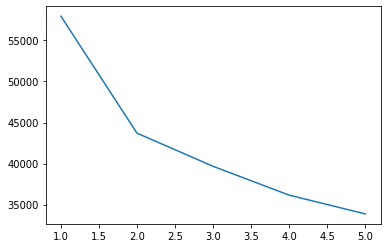

In [ ]:
# elbow method

wss= []
k = []
for x in np.arange(1,6,1):
    k.append(x)
    kmeans = KMeans(n_clusters=x, init='k-means++')
    kmeans.fit(data_concat)
    wss.append(kmeans.inertia_)
sns.lineplot(x=k, y=wss)

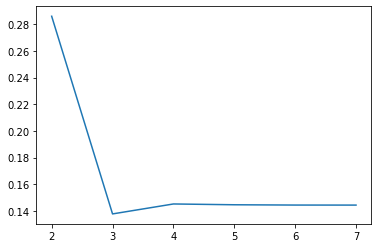

In [ ]:
ss= []
k = []
for x in np.arange(2,8,1):
    k.append(x)
    kmeans = KMeans(n_clusters=x, init='k-means++')
    kmeans.fit(data_concat)
    ss.append(silhouette_score(data_concat, kmeans.labels_))
sns.lineplot(x=k, y=ss)

In [ ]:
kmeans_data = KMeans(n_clusters=4, init='k-means++')
kmeans_data.fit(data_concat)

KMeans(n_clusters=4)

In [ ]:
kmeans_data.labels_

array([1, 3, 2, ..., 3, 3, 1], dtype=int32)

In [ ]:
data['cluster'] = kmeans_data.labels_
data

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary,cluster
0,0.38,0.53,2,157,3,0,1,0,sales,low,1
1,0.80,0.86,5,262,6,0,1,0,sales,medium,3
2,0.11,0.88,7,272,4,0,1,0,sales,medium,2
3,0.72,0.87,5,223,5,0,1,0,sales,low,3
4,0.37,0.52,2,159,3,0,1,0,sales,low,1
...,...,...,...,...,...,...,...,...,...,...,...
11995,0.90,0.55,3,259,10,1,0,1,management,high,3
11996,0.74,0.95,5,266,10,0,0,1,management,high,3
11997,0.85,0.54,3,185,10,0,0,1,management,high,3
11998,0.33,0.65,3,172,10,0,0,1,marketing,high,3


Cluster Checking

In [ ]:
data['cluster'].value_counts()

0    4779
1    4392
3    1532
2    1288
Name: cluster, dtype: int64

In [ ]:
data[data['cluster']==0].describe().T

,count,mean,std,min,25%,50%,75%,max
satisfaction_level,4779.0,0.686566,0.186188,0.09,0.55,0.69,0.84,1.0
last_evaluation,4779.0,0.701136,0.162572,0.36,0.56,0.69,0.84,1.0
number_project,4779.0,3.562670,0.969175,2.00,3.00,4.00,4.00,7.0
average_montly_hours,4779.0,195.109437,45.522100,96.00,156.00,192.00,235.00,310.0
time_spend_company,4779.0,2.809374,0.644606,2.00,2.00,3.00,3.00,4.0
Work_accident,4779.0,0.156937,0.363779,0.00,0.00,0.00,0.00,1.0
left,4779.0,0.078678,0.269263,0.00,0.00,0.00,0.00,1.0
promotion_last_5years,4779.0,0.024273,0.153911,0.00,0.00,0.00,0.00,1.0
cluster,4779.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.0


In [ ]:
data[data['cluster']==1].describe().T

,count,mean,std,min,25%,50%,75%,max
satisfaction_level,4392.0,0.675162,0.195382,0.11,0.52,0.69,0.84,1.0
last_evaluation,4392.0,0.696125,0.164691,0.36,0.55,0.68,0.84,1.0
number_project,4392.0,3.502732,1.008952,2.00,3.00,3.00,4.00,6.0
average_montly_hours,4392.0,192.148679,45.291786,96.00,153.00,187.00,230.25,310.0
time_spend_company,4392.0,2.813980,0.636515,2.00,2.00,3.00,3.00,4.0
Work_accident,4392.0,0.160291,0.366918,0.00,0.00,0.00,0.00,1.0
left,4392.0,0.124772,0.330498,0.00,0.00,0.00,0.00,1.0
promotion_last_5years,4392.0,0.005692,0.075240,0.00,0.00,0.00,0.00,1.0
cluster,4392.0,1.000000,0.000000,1.00,1.00,1.00,1.00,1.0


In [ ]:
data[data['cluster']==2].describe().T

,count,mean,std,min,25%,50%,75%,max
satisfaction_level,1288.0,0.208207,0.141005,0.09,0.11,0.16,0.24,0.78
last_evaluation,1288.0,0.781421,0.156479,0.36,0.68,0.82,0.90,1.00
number_project,1288.0,5.342391,1.124705,2.00,5.00,6.00,6.00,7.00
average_montly_hours,1288.0,235.576087,51.423668,98.00,199.00,250.00,275.00,310.00
time_spend_company,1288.0,4.190994,0.577361,2.00,4.00,4.00,5.00,6.00
Work_accident,1288.0,0.123447,0.329078,0.00,0.00,0.00,0.00,1.00
left,1288.0,0.426242,0.494722,0.00,0.00,0.00,1.00,1.00
promotion_last_5years,1288.0,0.009317,0.096110,0.00,0.00,0.00,0.00,1.00
cluster,1288.0,2.000000,0.000000,2.00,2.00,2.00,2.00,2.00


In [ ]:
data[data['cluster']==3].describe().T

,count,mean,std,min,25%,50%,75%,max
satisfaction_level,1532.0,0.676012,0.230457,0.12,0.55,0.75,0.85,1.0
last_evaluation,1532.0,0.769687,0.181045,0.36,0.62,0.83,0.92,1.0
number_project,1532.0,4.118146,1.072675,2.00,3.00,4.00,5.00,6.0
average_montly_hours,1532.0,211.560705,50.727711,97.00,171.00,226.00,253.00,307.0
time_spend_company,1532.0,5.982376,1.362108,5.00,5.00,6.00,6.00,10.0
Work_accident,1532.0,0.154700,0.361736,0.00,0.00,0.00,0.00,1.0
left,1532.0,0.338120,0.473224,0.00,0.00,0.00,1.00,1.0
promotion_last_5years,1532.0,0.032637,0.177743,0.00,0.00,0.00,0.00,1.0
cluster,1532.0,3.000000,0.000000,3.00,3.00,3.00,3.00,3.0


Berdasarkan hasil clustering sebelumnya, akan dibandingkan nilai mean dari masing-masing variabel yang kemudian akan diberi skor berdasarkan urutannya seperti pada tabel dibawah ini.

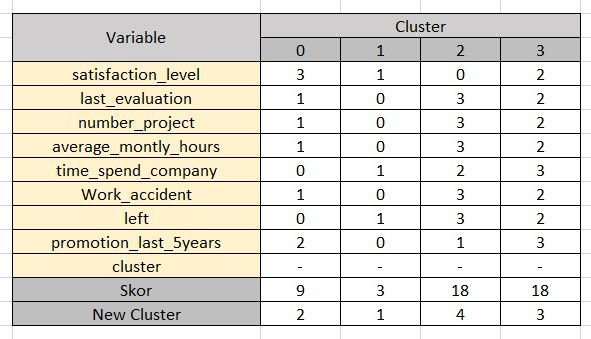

Hasil New Cluster pada tabel diatas akan digunakan untuk memberikan prioritas tindakan pencegahan resign dari pegawai. Semakin tinggi nilai cluster baru maka akan semakin tinggi prioritas perusahaan dalam mengupayakan agar karyawan tidak resign.

Pada cluster 3 dan 4 memiliki nilai total skor sama namun cluster 3 diberi prioritas lebih besar dikarenakan pada cluster ini pegawai rata-rata memiliki tingkat nilai kepuasan paling rendah dan hanya sedikit yang mendapatkan promosi dalam 5 tahun terakhir.

In [ ]:
# making new column for priority

z = {'cluster':[0,1,2,3],'score':[2,1,4,3]}
df_score = pd.DataFrame(data=z)
dict_scor = dict(df_score.values)
data['priority']= data['cluster'].map(dict_scor)
data

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary,cluster,priority
0,0.38,0.53,2,157,3,0,1,0,sales,low,1,1
1,0.80,0.86,5,262,6,0,1,0,sales,medium,3,3
2,0.11,0.88,7,272,4,0,1,0,sales,medium,2,4
3,0.72,0.87,5,223,5,0,1,0,sales,low,3,3
4,0.37,0.52,2,159,3,0,1,0,sales,low,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.90,0.55,3,259,10,1,0,1,management,high,3,3
11996,0.74,0.95,5,266,10,0,0,1,management,high,3,3
11997,0.85,0.54,3,185,10,0,0,1,management,high,3,3
11998,0.33,0.65,3,172,10,0,0,1,marketing,high,3,3
